In [1]:
import numpy as np

# Matrix transpose

A matrix is basically a collection of rows (or a collection of columns depending on the software you're using).

In [2]:
row1 = [1, 2, 3, 4]
row2 = [5, 6 ,7 , 8]
row3 = [9, 10, 11, 12]
matrix = np.array([row1, row2, row3])
print(matrix)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


However, what if we wanted to swap the rows and the columns? A matrix transpose lets us do this:

In [3]:
# Now, the first row becomes the first column
np.transpose(matrix)

# Or with this shorthand:
matrix.T

array([[ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11],
       [ 4,  8, 12]])

We often want to do this because matrix algebra often requires that rows / columns match up. For example, if you have two matrices of shape (a, b), and (c, b), then a dot product requires that the two inner dimensions be the same (this is why a dot product is often called an "inner product".

In [4]:
matrix.shape

(3, 4)

In [5]:
np.dot(matrix, matrix)

ValueError: shapes (3,4) and (3,4) not aligned: 4 (dim 1) != 3 (dim 0)

In [6]:
# Using a transpose allows us to compute the dot product
np.dot(matrix, matrix.T)

array([[ 30,  70, 110],
       [ 70, 174, 278],
       [110, 278, 446]])

# List comprehensions
`for` loops are one of the most common tools in coding. They let us iterate through a set of data and do something to each component. Here's how we'd write a for loop:

In [7]:
# Our original data
my_data = np.arange(10)

# We'll create an empty list and populate it with new values
new_data = []
for i_data in my_data:
    new_data.append(i_data ** 2)
print(my_data)
print(new_data)

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


However, what if we wanted a quicker way to do this. List comprehensions are a great way to very succinctly iterate through an object, do something on each iteration, and put the outputs in a list. The list will have length == `n_iterations`. For example...

In [8]:
# To create a list comprehension, we construct it like this:
new_data = [i_data ** 2 for i_data in my_data]
print(new_data)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


Now, we've collapsed 3 lines of code into 1! We can also use list comprehensions to create new variables from scratch:

In [9]:
my_names = ['name_%s' %i for i in range(10)]
print(my_names)

['name_0', 'name_1', 'name_2', 'name_3', 'name_4', 'name_5', 'name_6', 'name_7', 'name_8', 'name_9']


Or we can use it with a function:

In [10]:
def add_10_and_divide_by_2(num):
    return (num + 10) / 2.

new_data = [add_10_and_divide_by_2(i) for i in my_data]
print(new_data)

[5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]


List comprehensions are really powerful, but be careful. If the thing you're doing on each iteration is too complicated, it can make the code really hard to read. For example:

In [11]:
new_data = [np.abs(-1 * (i ** 2)) / np.ceil(((i ** 3) / 4. * 20)) for i in range(1, 10)]
print(new_data)

[0.20000000000000001, 0.10000000000000001, 0.066666666666666666, 0.050000000000000003, 0.040000000000000001, 0.033333333333333333, 0.028571428571428571, 0.025000000000000001, 0.022222222222222223]


If your list comprehension is more than simple, it's probably better to just use a `for` loop.

# Padding an array

In [12]:
# Side note for fancy code below: demo of how to pad an array
a = np.random.rand(2,3,2)
print('a ', a)
a_pad = np.pad(a, [(0,2), (0,0), (0,0)], mode='constant', constant_values=0)
print('a_pad ', a_pad)

('a ', array([[[ 0.58419013,  0.70809998],
        [ 0.91496589,  0.40087413],
        [ 0.92188999,  0.56815776]],

       [[ 0.41130417,  0.26131353],
        [ 0.19257956,  0.86267798],
        [ 0.6048264 ,  0.73677876]]]))
('a_pad ', array([[[ 0.58419013,  0.70809998],
        [ 0.91496589,  0.40087413],
        [ 0.92188999,  0.56815776]],

       [[ 0.41130417,  0.26131353],
        [ 0.19257956,  0.86267798],
        [ 0.6048264 ,  0.73677876]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]]))


# Creating an MNE events array
As we've all seen, it can be a little confusing to create an MNE events array from timing information. This is a quick overview of how to do this.

Let's say that we've got a list of event times (in seconds). We have two event types. How can we turn this into an array that MNE can use to chunk up our data into events (which are called `Epochs` in MNE)?

We basically need to do the following things:

1. Turn event times (in seconds) into sample indices
2. Create a unique integer for each event type, and assign one to each event.
3. Combine the above two items into an array of shape `(n_events, 3)`.
  * The first column will be the start of each event (in samples)
  * The second column can just be all zeros.
  * The third column is the integer for that event type.
4. (optional) create a dictionary that maps event type names onto the event type integers.

We'll step through this below...

In [24]:
import neurods as nds
import mne
import datascience as ds
import pandas as pd
import numpy as np
%matplotlib inline

# First read event times and some data
path_ecog = nds.io.data_list['ecog'] + 'chords_task/'
data = mne.io.Raw(path_ecog + 'ecog_resamp-raw.fif', preload=True)
time = ds.Table.read_table(path_ecog + 'meta_time.csv', index_col=0)
time

Opening raw data file /home/shared/cogneuro-connector/data/ecog/chords_task/ecog_resamp-raw.fif...
Isotrak not found
    Range : 0 ... 219521 =      0.000 ...   439.042 secs
Ready.
Reading 0 ... 219521  =      0.000 ...   439.042 secs...


start,type,stop
4.96914,consonant,5.66914
10.0105,consonant,10.7105
28.3729,consonant,29.0729
47.8371,consonant,48.5371
58.3871,consonant,59.0871
65.2148,consonant,65.9148
75.5478,consonant,76.2478
81.1567,consonant,81.8567
84.729,consonant,85.429
86.5149,consonant,87.2149


## 1. Convert event times (in seconds) to event times in samples.

In [3]:
# We'll use the sampling frequency to convert seconds to samples
sfreq = data.info['sfreq']

# Now do the conversion
indices = sfreq * time['start']

# Make sure that indices are now integers (since they refer to indices in the data)
indices = indices.astype(int)

## 2. Create a unique integer for each event type

In [5]:
trial_types = time['type']
print(trial_types)

['consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'consonant' 'consonant' 'consonant' 'consonant' 'consonant' 'consonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'dissonant'
 'dissonant' 'dissonant' 'dissonant' 'dissonant' 'm

In [8]:
# Now create a vector of integers, one for each trial type
trial_type_nums = trial_types.copy()
unique_trials = np.unique(trial_types)
print(unique_trials)

['consonant' 'dissonant' 'meow']


In [9]:
# We'll iterate through each unique trial type
# we'll assign its integer to the corresponding trials
for i, name in enumerate(unique_trials):
    mask = trial_types == name
    trial_type_nums[mask] = i
    
# Again, make sure that these are integers.
trial_type_nums = trial_type_nums.astype(int)
trial_type_nums

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 3. Combine the above into an MNE events array
These are all "row" vectors, but we want them to be "columns". To do this, we'll first stack them vertically (so it is shape `3 x n_events`), and then we'll transpose this matrix (so it will then be shape `n_events x 3`):

In [15]:
# First column is the trial index vector
first_col = indices

# Second column can just be zeros
second_col = np.zeros_like(first_col)

# Third column is the trial type numbers
third_col = trial_type_nums

In [19]:
events = np.vstack([first_col, second_col, third_col])
events = events.transpose()
print(events.shape)
print('\n---\n')
print(events[:5])

(105, 3)

---

[[ 2484     0     0]
 [ 5005     0     0]
 [14186     0     0]
 [23918     0     0]
 [29193     0     0]]


## 4. Create a dictionary mapping event types to event ID numbers
When we created the unique event IDs, we also could have created this info dictionary like this:

In [21]:
# Create an empty dictionary
event_ids = dict()

# Now populate it with the unique ID for each event type
for i, name in enumerate(unique_trials):
    event_ids[name] = i
    
print(event_ids)

{'meow': 2, 'dissonant': 1, 'consonant': 0}


## Now, we have everything we need to create `Epochs` objects

In [26]:
epochs = mne.Epochs(data, events, event_ids, tmin=-.2, tmax=.5)

The events passed to the Epochs constructor are not chronologically ordered.
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


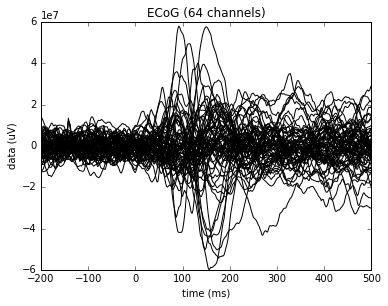

In [28]:
_ = epochs.average().plot()